# Transformation to OpenFOAM Code (Simple)

## Imports

In [ ]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np

from library.python.fvm.solver_jax import Settings
from library.model.models.shallow_water import ShallowWaterEquations

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.python.misc.misc import Zstruct
import library.python.transformation.to_openfoam as trafo
import library.python.mesh.mesh as petscMesh


## Model definition

In [ ]:
bcs = BC.BoundaryConditions(
    [
        BC.Wall(physical_tag="wall"),
        BC.Wall(physical_tag="inflow"),
        BC.Wall(physical_tag="outflow"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowWaterEquations(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

# the mesh is necessary to connect the boundary conditions to the mesh tags
main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)
model.initialize_boundary_conditions(mesh)

## Sympy Model

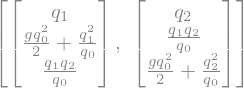

In [ ]:
model.flux()

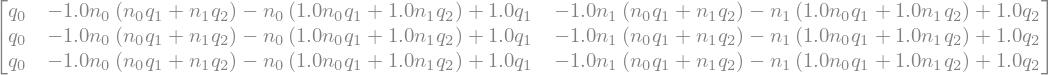

In [ ]:
model.print_boundary_conditions()

## Code transformation

In [ ]:
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/trafo", filename="swe.h5"))
trafo.write_code(model, settings)

2025-10-19 13:10:36.334 | WARNING  | library.python.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


## Check the output

In [ ]:
main_dir = os.getenv("ZOOMY_DIR")
path = os.path.join(main_dir, os.path.join(settings.output.directory, '.foam_interface/Model.H'))
with open(path, "r") as f:
    print(f.read())


#pragma once
#include "List.H"
#include "vector.H"
#include "scalar.H"

namespace Model
{
constexpr int n_dof_q    = 3;
constexpr int n_dof_qaux = 2;
constexpr int dimension  = 2;
const Foam::List<Foam::word> map_boundary_tag_to_function_index{ "wall", "inflow", "outflow" };

inline Foam::List<Foam::List<Foam::scalar>> flux_x(
    const Foam::List<Foam::scalar>& Q,
    const Foam::List<Foam::scalar>& Qaux)
{
    auto res = Foam::List<Foam::List<Foam::scalar>>(3, Foam::List<Foam::scalar>(1, 0.0));
    Foam::scalar t0 = (1.0 / Foam::pow(Q[0], 1));
        res[0][0] = Q[1];
        res[1][0] = (1.0/2.0)*9.81*Foam::pow(Q[0], 2) + Foam::pow(Q[1], 2)*t0;
        res[2][0] = Q[1]*Q[2]*t0;
    return res;
}
        

inline Foam::List<Foam::List<Foam::scalar>> flux_y(
    const Foam::List<Foam::scalar>& Q,
    const Foam::List<Foam::scalar>& Qaux)
{
    auto res = Foam::List<Foam::List<Foam::scalar>>(3, Foam::List<Foam::scalar>(1, 0.0));
    Foam::scalar t0 = (1.0 / Foam::pow(Q[0], 1));
      